In [1]:
# This should be called before numpy is imported.
import os
os.environ["OMP_NUM_THREADS"] = '1'

import importlib 

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

In [167]:
pd.options.mode.chained_assignment = None

In [166]:
import warnings
warnings.filterwarnings(action = 'ignore', module = 'matplotlib\..*')
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [4]:
games = pd.read_json('data/RPGproducts.json')

In [5]:
games

,name,tags,num_reviews,num_positive_reviews,url,release_month,release_day,release_year
0,Karpov,"[RPG, Visual Novel, Simulation, Horror, Multip...",1.0,1.0,https://store.steampowered.com/app/2328680/Kar...,4,9,2023
1,Holy Catch,"[Adventure, RPG, Action-Adventure, Action RPG,...",NaN,NaN,https://store.steampowered.com/app/2350760/Hol...,4,8,2023
2,Sakura Kanji Ketchi,"[Casual, RPG, Action RPG, Education, Trivia, 2...",NaN,NaN,https://store.steampowered.com/app/2364800/Sak...,4,8,2023
3,Mechaneer Resta's Grand Adventure,"[Adventure, RPG, JRPG, 2D, Singleplayer, Anime...",19.0,14.0,https://store.steampowered.com/app/2219800/Mec...,4,7,2023
4,Adventures of Skye the Slime Maid,"[Casual, RPG, Visual Novel, Anime, Colorful, T...",0.0,0.0,https://store.steampowered.com/app/2106600/Adv...,4,7,2023
...,...,...,...,...,...,...,...,...
10011,Takara Cards,"[Early Access, Turn-Based Tactics, Roguelite, ...",19.0,19.0,https://store.steampowered.com/app/1932210/Tak...,3,28,2023
10012,The Ship: Murder Party,"[Multiplayer, Indie, First-Person, Action, Ste...",2538.0,2129.0,https://store.steampowered.com/app/2400/The_Sh...,7,11,2006
10013,Bakeborough,"[Indie, Adventure, Pixel Graphics, Colorful, C...",1.0,1.0,https://store.steampowered.com/app/2093050/Bak...,3,28,2023
10014,赌神模拟器：亚洲风云God Of Gamblers,"[Sexual Content, Nudity, Mature, Gambling, Mys...",133.0,40.0,https://store.steampowered.com/app/2091550/God...,3,28,2023


## Preprocessing

In this step, we will preprocess the 'tags' column of the data and vectorize it for the upcoming steps.

In [6]:
games['tags'] = games['tags'].apply(lambda x: [tag.replace(" ", "").replace("-", "").lower() for tag in x])

In [7]:
games['tags'] = games['tags'].apply(lambda x: list(set(x)))

In [8]:
games[['num_reviews', 'num_positive_reviews']] = games[['num_reviews', 'num_positive_reviews']].fillna(0)

In [9]:
games

,name,tags,num_reviews,num_positive_reviews,url,release_month,release_day,release_year
0,Karpov,"[exploration, narration, psychologicalhorror, ...",1.0,1.0,https://store.steampowered.com/app/2328680/Kar...,4,9,2023
1,Holy Catch,"[pixelgraphics, openworld, actionadventure, fi...",0.0,0.0,https://store.steampowered.com/app/2350760/Hol...,4,8,2023
2,Sakura Kanji Ketchi,"[earlyaccess, cartoony, handdrawn, femaleprota...",0.0,0.0,https://store.steampowered.com/app/2364800/Sak...,4,8,2023
3,Mechaneer Resta's Grand Adventure,"[nudity, hentai, anime, singleplayer, rpg, nsf...",19.0,14.0,https://store.steampowered.com/app/2219800/Mec...,4,7,2023
4,Adventures of Skye the Slime Maid,"[anime, comedy, visualnovel, rpg, textbased, s...",0.0,0.0,https://store.steampowered.com/app/2106600/Adv...,4,7,2023
...,...,...,...,...,...,...,...,...
10011,Takara Cards,"[earlyaccess, handdrawn, anime, tacticalrpg, d...",19.0,19.0,https://store.steampowered.com/app/1932210/Tak...,3,28,2023
10012,The Ship: Murder Party,"[mystery, stealth, firstperson, comedy, rpg, f...",2538.0,2129.0,https://store.steampowered.com/app/2400/The_Sh...,7,11,2006
10013,Bakeborough,"[exploration, psychologicalhorror, earlyaccess...",1.0,1.0,https://store.steampowered.com/app/2093050/Bak...,3,28,2023
10014,赌神模拟器：亚洲风云God Of Gamblers,"[datingsim, anime, nsfw, casual, mystery, 3d, ...",133.0,40.0,https://store.steampowered.com/app/2091550/God...,3,28,2023


In [10]:
all_tags  = []

for tags in games.tags:
    for tag in tags:
        if tag not in all_tags:
            all_tags.append(tag)

In [11]:
print(len(all_tags))
print(all_tags)

425
['exploration', 'narration', 'psychologicalhorror', 'atmospheric', 'simulation', 'emotional', 'visualnovel', 'rpg', 'singleplayer', 'storyrich', '2dplatformer', '2d', 'indie', 'multipleendings', 'horror', 'choicesmatter', 'pixelgraphics', 'openworld', 'actionadventure', 'fishing', 'action', 'nature', 'offroad', 'actionrpg', 'adventure', 'earlyaccess', 'cartoony', 'handdrawn', 'femaleprotagonist', 'education', 'cute', 'topdown', 'casual', 'combat', 'trivia', 'crafting', 'nudity', 'hentai', 'anime', 'nsfw', 'jrpg', 'sexualcontent', 'comedy', 'textbased', 'fantasy', 'colorful', 'datingsim', 'crpg', 'relaxing', 'memes', 'puzzle', 'tacticalrpg', 'wordgame', 'freetoplay', 'military', 'massivelymultiplayer', 'grandstrategy', 'strategyrpg', 'war', 'wargame', 'strategy', 'multiplayer', 'medieval', 'rts', 'pvp', 'conspiracy', 'turnbasedstrategy', 'political', 'stylized', 'tactical', 'drama', 'turnbasedtactics', 'pve', 'idler', 'automation', 'mmorpg', 'minimalist', 'clicker', 'interactivefict

In [12]:
rpg_tags = set(tag for tag in all_tags if ('rpg' in tag))
rpg_tags

{'actionrpg',
 'crpg',
 'jrpg',
 'mmorpg',
 'partybasedrpg',
 'rpg',
 'rpgmaker',
 'strategyrpg',
 'tacticalrpg'}

In [13]:
games['tags'] = games['tags'].apply(lambda x: [tag for tag in x if tag != 'rpg'])

In [14]:
games['tags']

0        [exploration, narration, psychologicalhorror, ...
1        [pixelgraphics, openworld, actionadventure, fi...
2        [earlyaccess, cartoony, handdrawn, femaleprota...
3        [nudity, hentai, anime, singleplayer, nsfw, ac...
4        [anime, comedy, visualnovel, textbased, single...
                               ...                        
10011    [earlyaccess, handdrawn, anime, tacticalrpg, d...
10012    [mystery, stealth, firstperson, comedy, fps, r...
10013    [exploration, psychologicalhorror, earlyaccess...
10014    [datingsim, anime, nsfw, casual, mystery, 3d, ...
10015    [isometric, turnbased, creaturecollector, indi...
Name: tags, Length: 10016, dtype: object

In [15]:
tag_dict  = {}

for tags in games.tags:
    for tag in tags:
        if tag not in tag_dict:
            tag_dict[tag] = 1
        else:
            tag_dict[tag] += 1

tag_counts = pd.DataFrame(tag_dict.items(), columns=['tag', 'count'])

In [16]:
tag_counts.sort_values(by = ['count'], inplace = True, ascending = False)
tag_counts.reset_index(drop = True, inplace = True)

<AxesSubplot: ylabel='count'>

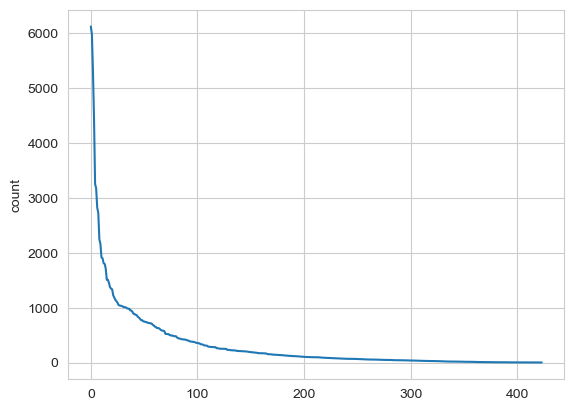

In [17]:
sns.lineplot(x = tag_counts.index, y = 'count', data = tag_counts)

In [18]:
tag_counts[0:50]

,tag,count
0,indie,6128
1,adventure,5989
2,singleplayer,5313
3,action,4452
4,2d,3257
5,fantasy,3177
6,casual,2823
7,strategy,2730
8,storyrich,2250
9,pixelgraphics,2163


In [19]:
tag_counts[50:100]

,tag,count
50,darkfantasy,749
51,visualnovel,741
52,strategyrpg,737
53,difficult,728
54,greatsoundtrack,723
55,sandbox,717
56,partybasedrpg,714
57,tacticalrpg,713
58,chooseyourownadventure,690
59,sexualcontent,677


In [20]:
tag_counts[100:150]

,tag,count
100,cardgame,358
101,zombies,351
102,permadeath,350
103,linear,334
104,realistic,332
105,soulslike,329
106,romance,316
107,basebuilding,311
108,mmorpg,310
109,cartoon,307


In [21]:
tag_counts[150:200]

,tag,count
150,classbased,189
151,surreal,188
152,idler,186
153,beat'emup,183
154,shoot'emup,181
155,rts,178
156,stealth,177
157,localmultiplayer,171
158,openworldsurvivalcraft,171
159,towerdefense,170


In [22]:
cutoff = 149
tag_counts.loc[0:cutoff, 'tag']

0                   indie
1               adventure
2            singleplayer
3                  action
4                      2d
              ...        
145     gridbasedmovement
146    thirdpersonshooter
147             darkhumor
148             swordplay
149        mysterydungeon
Name: tag, Length: 150, dtype: object

In [26]:
top_tags = set(tag_counts.loc[0:cutoff, 'tag'])

In [27]:
games_top_tags = games

In [28]:
games_top_tags['tags'] = games_top_tags['tags'].apply(lambda x: list(set(x).intersection(top_tags)) if not set(x).isdisjoint(top_tags) else [])
games_top_tags

,name,tags,num_reviews,num_positive_reviews,url,release_month,release_day,release_year
0,Karpov,"[exploration, psychologicalhorror, atmospheric...",1.0,1.0,https://store.steampowered.com/app/2328680/Kar...,4,9,2023
1,Holy Catch,"[openworld, actionadventure, singleplayer, act...",0.0,0.0,https://store.steampowered.com/app/2350760/Hol...,4,8,2023
2,Sakura Kanji Ketchi,"[earlyaccess, cartoony, handdrawn, cute, topdo...",0.0,0.0,https://store.steampowered.com/app/2364800/Sak...,4,8,2023
3,Mechaneer Resta's Grand Adventure,"[nudity, hentai, anime, singleplayer, action, ...",19.0,14.0,https://store.steampowered.com/app/2219800/Mec...,4,7,2023
4,Adventures of Skye the Slime Maid,"[anime, comedy, visualnovel, singleplayer, tex...",0.0,0.0,https://store.steampowered.com/app/2106600/Adv...,4,7,2023
...,...,...,...,...,...,...,...,...
10011,Takara Cards,"[earlyaccess, handdrawn, roguelike, cardgame, ...",19.0,19.0,https://store.steampowered.com/app/1932210/Tak...,3,28,2023
10012,The Ship: Murder Party,"[funny, difficult, firstperson, comedy, simula...",2538.0,2129.0,https://store.steampowered.com/app/2400/The_Sh...,7,11,2006
10013,Bakeborough,"[exploration, psychologicalhorror, earlyaccess...",1.0,1.0,https://store.steampowered.com/app/2093050/Bak...,3,28,2023
10014,赌神模拟器：亚洲风云God Of Gamblers,"[drama, datingsim, nudity, 3d, hentai, anime, ...",133.0,40.0,https://store.steampowered.com/app/2091550/God...,3,28,2023


In [174]:
list_tags = games_top_tags['tags'].apply(lambda x: len(x))
list_tags.describe()

count    10016.000000
mean        12.306010
std          5.287832
min          0.000000
25%          8.000000
50%         14.000000
75%         17.000000
max         19.000000
Name: tags, dtype: float64

In [29]:
top_games_top_tags = games_top_tags[games_top_tags['num_reviews'] > 100]

In [30]:
sum(top_games_top_tags['tags'].apply(lambda x: len(x) < 0))

0

In [31]:
tags_array = list(top_games_top_tags['tags']) 

In [32]:
vectorizer = CountVectorizer(analyzer = lambda x : x)
X = vectorizer.fit_transform(tags_array).toarray()

In [33]:
X.shape

(3379, 150)

In [34]:
vectorizer.get_feature_names_out()

array(["1990's", '2.5d', '2d', '2dplatformer', '3d', '3dplatformer',
       'action', 'actionadventure', 'actionroguelike', 'actionrpg',
       'adventure', 'anime', 'arcade', 'atmospheric', 'basebuilding',
       'boardgame', 'building', 'bullethell', 'cardbattler', 'cardgame',
       'cartoon', 'cartoony', 'casual', 'charactercustomization',
       'choicesmatter', 'chooseyourownadventure', 'classic', 'clicker',
       'colorful', 'combat', 'comedy', 'controller', 'conversation',
       'coop', 'crafting', 'crpg', 'cute', 'cyberpunk', 'dark',
       'darkfantasy', 'darkhumor', 'datingsim', 'deckbuilding', 'demons',
       'difficult', 'dragons', 'drama', 'dungeoncrawler', 'earlyaccess',
       'emotional', 'exploration', 'familyfriendly', 'fantasy',
       'femaleprotagonist', 'firstperson', 'fps', 'freetoplay', 'funny',
       'futuristic', 'gore', 'greatsoundtrack', 'gridbasedmovement',
       'hackandslash', 'handdrawn', 'hentai', 'historical', 'horror',
       'immersivesim', 'in

In [35]:
games[['num_reviews', 'num_positive_reviews']].describe()

,num_reviews,num_positive_reviews
count,1.001600e+04,1.001600e+04
mean,1.731649e+03,1.475987e+03
std,2.450548e+04,2.095829e+04
min,0.000000e+00,0.000000e+00
25%,6.000000e+00,4.000000e+00
50%,2.900000e+01,2.100000e+01
75%,2.200000e+02,1.670000e+02
max,1.960357e+06,1.619019e+06


## PCA

In [36]:
pca = PCA()
X_pca = pca.fit_transform(X)

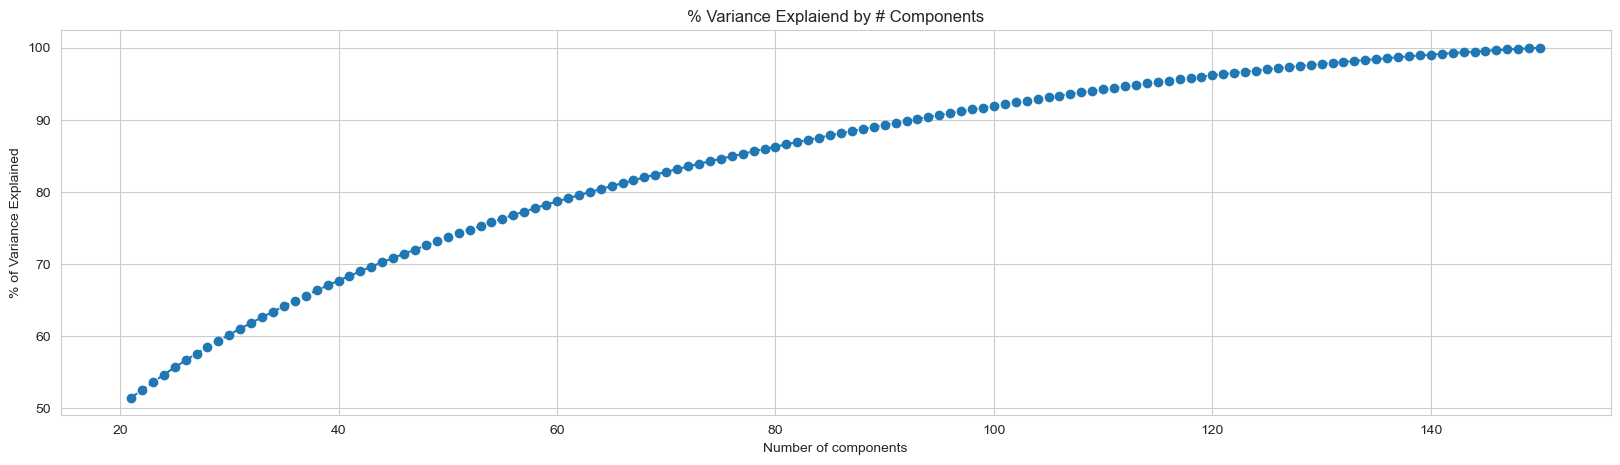

In [37]:
cumulative_variance_ratio = 100*np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (20,5))
plt.plot(range(21,151), cumulative_variance_ratio[20:], marker = 'o', linestyle = '--')
plt.xlabel('Number of components')
plt.ylabel('% of Variance Explained')
plt.title('% Variance Explaiend by # Components')

plt.show()

In [38]:
pca_n = PCA(n_components = 0.95)
X_pca_n = pca_n.fit_transform(X)

## KMeans

In [39]:
k_range = range(10, 61)

inertia = []
silhouette = []
for k in k_range:
    K_model = KMeans(n_clusters = k, max_iter = 200, init = 'k-means++', n_init = 10)
    K_model.fit(X_pca_n)
    inertia.append(K_model.inertia_)
    
    cluster_labels = K_model.fit_predict(X_pca_n)
    silhouette.append(silhouette_score(X_pca_n, cluster_labels))

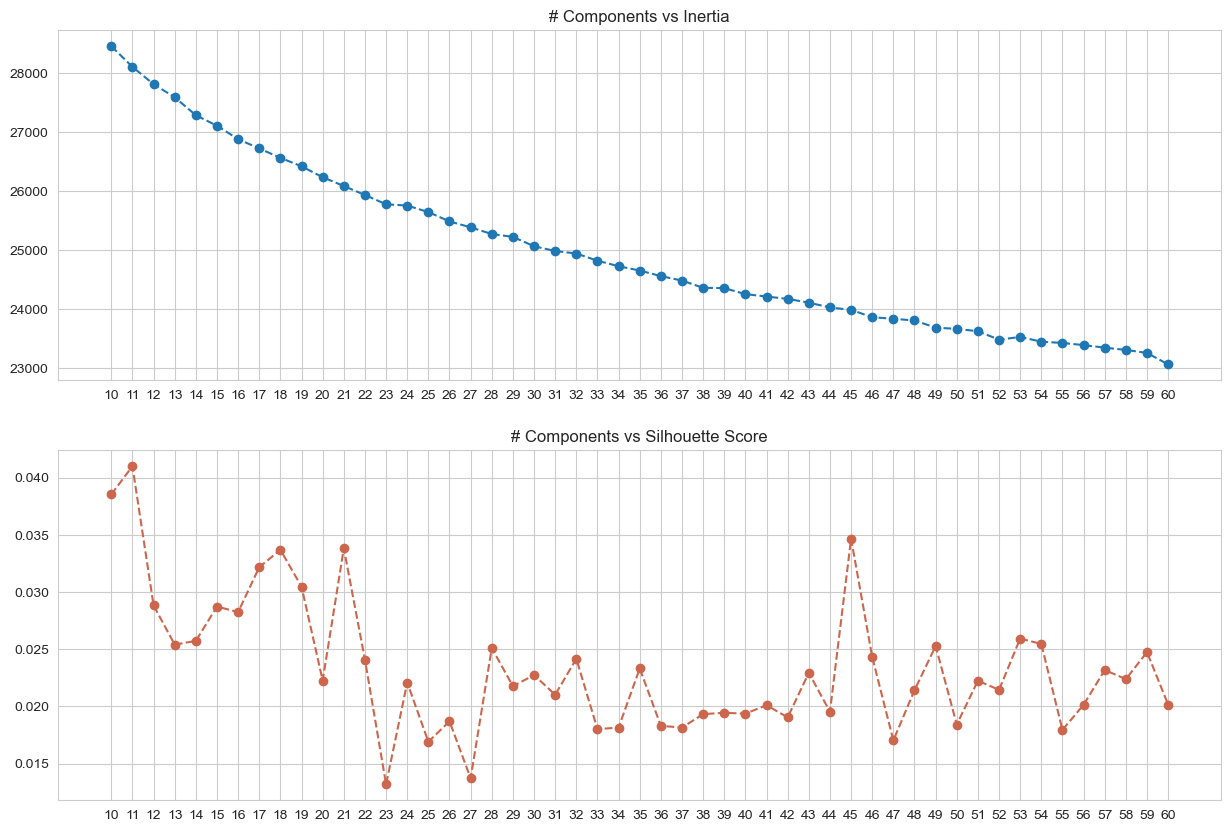

In [40]:
fig, axs = plt.subplots(2, 1, figsize = (15, 10))

axs[0].plot(k_range, inertia, marker = 'o', linestyle = '--')
axs[0].set_xticks(k_range)
axs[0].title.set_text('# Components vs Inertia')

axs[1].plot(k_range, silhouette, marker = 'o', linestyle = '--', color=[0.8, 0.4, 0.3])
axs[1].set_xticks(k_range)
axs[1].title.set_text('# Components vs Silhouette Score')

plt.show()

In [41]:
n_clusters = 21
model_n = KMeans(n_clusters = n_clusters, max_iter = 200, init = 'k-means++', n_init = 10)
model_n.fit(X_pca_n)

KMeans(max_iter=200, n_clusters=21, n_init=10)

In [168]:
rpg_cluster = top_games_top_tags
rpg_cluster['cluster'] = model_n.labels_

In [45]:
rpg_cluster.reset_index(drop = True, inplace = True)

In [46]:
rpg_cluster[['name', 'tags', 'cluster']]

,name,tags,cluster
0,EA SPORTS™ PGA TOUR™,"[coop, localcoop, onlinecoop, multiplayer, spo...",19
1,Song Of The Prairie,"[drama, exploration, datingsim, openworld, ear...",18
2,EVERSPACE™ 2,"[openworld, 3d, atmospheric, actionadventure, ...",1
3,Organs Please,"[survival, futuristic, simulation, basebuildin...",9
4,Spiritfall,"[hackandslash, cartoon, earlyaccess, cartoony,...",8
...,...,...,...
3374,Dungeon Siege II,"[hackandslash, isometric, coop, loot, adventur...",14
3375,Disciples II: Rise of the Elves,"[turnbased, atmospheric, turnbasedstrategy, cl...",7
3376,Disciples II: Gallean's Return,"[isometric, atmospheric, turnbased, singleplay...",7
3377,The Ship: Murder Party,"[funny, difficult, firstperson, comedy, simula...",4


In [47]:
rpg_cluster[rpg_cluster['cluster'] == 0][['name', 'tags']].head(30)

,name,tags
14,Gothic 1,"[openworld, atmospheric, difficult, adventure,..."
23,The First Templar - Steam Special Edition,"[hackandslash, historical, openworld, coop, si..."
31,Sea Dogs: To Each His Own - Pirate Open World RPG,"[historical, openworld, 3d, choicesmatter, sin..."
60,Captain Bones,"[exploration, survival, openworld, earlyaccess..."
69,Dungeon Defenders: Going Rogue,"[earlyaccess, pve, colorful, cartoony, onlinec..."
112,Lichdom: Battlemage,"[openworld, earlyaccess, atmospheric, difficul..."
144,DARK SOULS™ II,"[exploration, openworld, coop, atmospheric, di..."
151,LEGO® The Hobbit™,"[openworld, familyfriendly, atmospheric, coop,..."
158,Adventure Time: Finn and Jake's Epic Quest,"[cartoon, openworld, familyfriendly, 3d, comed..."
193,The Memory of Eldurim,"[openworld, earlyaccess, firstperson, singlepl..."


In [48]:
rpg_cluster[rpg_cluster['cluster'] == 1][['name', 'tags']].head(30)

,name,tags
2,EVERSPACE™ 2,"[openworld, 3d, atmospheric, actionadventure, ..."
19,Nienix: Cosmic Warfare,"[openworld, pve, loot, proceduralgeneration, b..."
35,"BEARS, VODKA, BALALAIKA! 🐻","[historical, psychologicalhorror, realistic, f..."
66,Ultra Age,"[hackandslash, 3d, pve, anime, difficult, acti..."
141,Vangers,"[openworld, psychologicalhorror, atmospheric, ..."
149,Super Motherload,"[exploration, familyfriendly, loot, procedural..."
157,Hard Truck Apocalypse: Arcade / Ex Machina: Ar...,"[atmospheric, postapocalyptic, singleplayer, a..."
163,Planet Alcatraz,"[isometric, atmospheric, comedy, singleplayer,..."
164,Hard Truck Apocalypse / Ex Machina,"[openworld, atmospheric, oldschool, postapocal..."
168,Drox Operative,"[coop, loot, proceduralgeneration, singleplaye..."


In [49]:
rpg_cluster[rpg_cluster['cluster'] == 2][['name', 'tags']].head(30)

,name,tags
29,Zoria: Age of Shattering Prologue,"[exploration, freetoplay, atmospheric, tactica..."
47,Stygian: Reign of the Old Ones,"[isometric, atmospheric, crpg, choicesmatter, ..."
71,Black Geyser: Couriers of Darkness,"[isometric, exploration, openworld, crpg, olds..."
96,Geneforge 1 - Mutagen,"[isometric, gridbasedmovement, turnbased, crpg..."
109,Lords of Xulima,"[isometric, turnbased, crpg, oldschool, diffic..."
202,Divinity: Original Sin (Classic),"[isometric, openworld, coop, atmospheric, crpg..."
212,Final Fantasy III (3D Remake),"[openworld, turnbased, oldschool, difficult, t..."
239,Heroes of a Broken Land,"[gridbasedmovement, turnbased, firstperson, pr..."
250,Shadowrun: Dragonfall - Director's Cut,"[isometric, atmospheric, cyberpunk, crpg, turn..."
255,Elminage Gothic,"[exploration, gridbasedmovement, turnbased, cr..."


In [50]:
rpg_cluster[rpg_cluster['cluster'] == 19][['name', 'tags']].head(30)

,name,tags
0,EA SPORTS™ PGA TOUR™,"[coop, localcoop, onlinecoop, multiplayer, spo..."
13,重明鸟 Bright Bird,"[atmospheric, platformer, puzzle, indie, adven..."
24,梅塔特隆 Metatron,"[difficult, anime, action, 2d, indie, soulslike]"
26,Sherlock Holmes - Nemesis,"[firstperson, puzzle, adventure, point&click, ..."
61,云聚：失落的魔法 Magic Ganglia,[indie]
62,巴伦西亚传说：索菲亚的重生 Valencia Saga:Sophia's rebirth,"[simulation, strategy]"
101,Learn Japanese To Survive! Katakana War,"[anime, singleplayer, visualnovel, indie, stra..."
110,Data Hacker: Initiation,"[simulation, indie, pixelgraphics, adventure, ..."
133,Rogue's Tale,"[turnbased, roguelike, permadeath, difficult, ..."
134,Konung 2,"[isometric, fantasy]"


In [51]:
rpg_cluster.to_csv('data/top_rpg_cluster_21.csv')

## Cluster Analysis

In [52]:
from math import dist, ceil

In [67]:
rpg_cluster.groupby('cluster').size()

cluster
0     179
1     153
2      96
3     130
4     100
5     147
6      95
7     154
8     194
9     114
10    153
11    189
12    185
13    103
14    140
15    163
16    184
17    156
18    179
19    393
20    172
dtype: int64

In [68]:
rpg_cluster[['num_reviews','cluster']].groupby('cluster').describe()

num_reviews                                                      \
              count          mean            std    min     25%     50%   
cluster                                                                   
0             179.0  15084.648045   65429.768097  102.0  372.50  1375.0   
1             153.0   5965.464052   42561.933482  103.0  226.00   514.0   
2              96.0   3338.010417    8244.137553  107.0  249.25   535.5   
3             130.0   2306.515385    7346.355000  101.0  179.00   433.0   
4             100.0   5721.720000   13330.375242  106.0  382.50  1004.0   
5             147.0   3309.904762   14611.161446  103.0  222.50   623.0   
6              95.0    579.263158    1099.413801  101.0  179.00   273.0   
7             154.0   3038.571429    7364.468590  102.0  296.00   690.5   
8             194.0   5590.927835   21218.374003  103.0  252.00   576.0   
9             114.0   4191.850877   11523.410734  104.0  272.25   719.0   
10            153.0   2001.594771    9343.312719  101.0  174.00   391.0   
11            189.0  12256.301587   47988.056701  105.0  379.00  1527.0   
12            185.0  20449.697297  145781.368934  103.0  440.00  1840.0   
13            103.0   1630.359223    2611.448279  115.0  281.00   694.0   
14            140.0   3206.757143    8533.762714  106.0  261.50   560.5   
15            163.0   2711.509202    8407.305610  106.0  291.00   691.0   
16            184.0   2354.211957   10656.995440  103.0  174.00   415.0   
17            156.0   2720.820513    6400.089254  101.0  245.50   592.5   
18            179.0   4855.223464   35454.752092  106.0  200.50   460.0   
19            393.0    350.315522     492.726900  101.0  135.00   204.0   
20            172.0   2934.116279   12078.184629  102.0  237.00   478.0   

                             
             75%        max  
cluster                      
0        6054.00   648362.0  
1        1616.00   522107.0  
2        2736.00    69444.0  
3        1459.75    51081.0  
4        3358.75    87193.0  
5        2059.00   172200.0  
6         586.00    10013.0  
7        1753.25    62125.0  
8        2467.00   205712.0  
9        2267.50    68934.0  
10       1188.00   112785.0  
11       4894.00   473902.0  
12       7719.00  1960357.0  
13       1536.00    15253.0  
14       2469.00    69160.0  
15       1669.00    82802.0  
16       1313.00   139714.0  
17       1918.25    50499.0  
18       1869.00   470706.0  
19        363.00     5682.0  
20       1597.50   111020.0

In [53]:
def find_nearest_points(center, points):
    nearest = points.pop()
    d_nearest = dist(center, nearest)
    for point in points:
        if dist(center, point) < d_nearest:
            nearest = point
            d_nearest = dist(center, nearest)

In [54]:
nearest_i = []

for n in range(n_clusters):
    all_i = np.where(model_n.labels_ == n)[0]
    points = X_pca_n[all_i]
    n_points = points.shape[0]
    
    center = model_n.cluster_centers_[n]
    
    distances = [dist(points[k], center) for k in range(n_points)]
    min_i = int(np.argmin(distances))
    min_i = all_i[min_i]
    nearest_i.append(int(min_i))
    
nearest_i

[3208,
 2937,
 2938,
 356,
 3364,
 387,
 2568,
 136,
 2547,
 1028,
 1954,
 726,
 103,
 2042,
 114,
 1868,
 3019,
 1757,
 418,
 61,
 2471]

In [55]:
rpg_cluster.loc[nearest_i][['name', 'tags', 'cluster']]

,name,tags,cluster
3208,Gothic 3: Forsaken Gods Enhanced Edition,"[openworld, atmospheric, singleplayer, thirdpe...",0
2937,Salvation Prophecy,"[simulation, singleplayer, thirdperson, action...",1
2938,Realms of Arkania: Blade of Destiny,"[turnbased, crpg, firstperson, singleplayer, f...",2
356,Doom & Destiny,"[pixelgraphics, rpgmaker, adventure, comedy, s...",3
3364,The Ship: Single Player,"[firstperson, singleplayer, fps, action, multi...",4
387,Why Am I Dead At Sea,"[pixelgraphics, singleplayer, storyrich, great...",5
2568,Princess Project,"[nudity, hentai, anime, memes, mature, indie, ...",6
136,Ascension to the Throne,"[turnbased, singleplayer, turnbasedstrategy, s...",7
2547,bit Dungeon,"[roguelike, actionroguelike, action, indie, ro...",8
1028,Urban Empire,"[historical, simulation, singleplayer, managem...",9


In [169]:
silhouette_coeff = silhouette_samples(X, cluster_labels)
rpg_cluster['silhouette_coeff'] = silhouette_coeff

In [62]:
rep_games = rpg_cluster[rpg_cluster['silhouette_coeff'] > 0].sort_values('num_reviews').drop_duplicates(['cluster'], keep='last')[['name', 'tags', 'cluster', 'silhouette_coeff']].sort_values('cluster')
rep_games

,name,tags,cluster,silhouette_coeff
396,The Witcher® 3: Wild Hunt,"[atmospheric, dark, fantasy, singleplayer, thi...",0,0.081583
369,Elite Dangerous,"[exploration, openworld, difficult, adventure,...",1,0.064040
2702,Disco Elysium - The Final Cut,"[isometric, exploration, openworld, atmospheri...",2,0.030822
3080,To the Moon,"[linear, interactivefiction, emotional, female...",3,0.035161
3340,Borderlands 3,"[openworld, nudity, coop, loot, adventure, fir...",4,0.028376
479,Undertale,"[datingsim, cute, bullethell, 2d, dark, psycho...",5,0.014239
1854,Treasure Hunter Claire,"[nudity, multipleendings, hentai, anime, cute,...",6,0.360833
629,XCOM® 2,"[openworld, coop, atmospheric, turnbased, perm...",7,0.010974
2541,Hades,"[isometric, hackandslash, atmospheric, rogueli...",8,0.043049
2648,Crusader Kings III,"[historical, war, simulation, singleplayer, li...",9,0.017566


In [63]:
labels = model_n.labels_
features = vectorizer.get_feature_names_out()

In [74]:
reps = rep_games['name'].tolist()

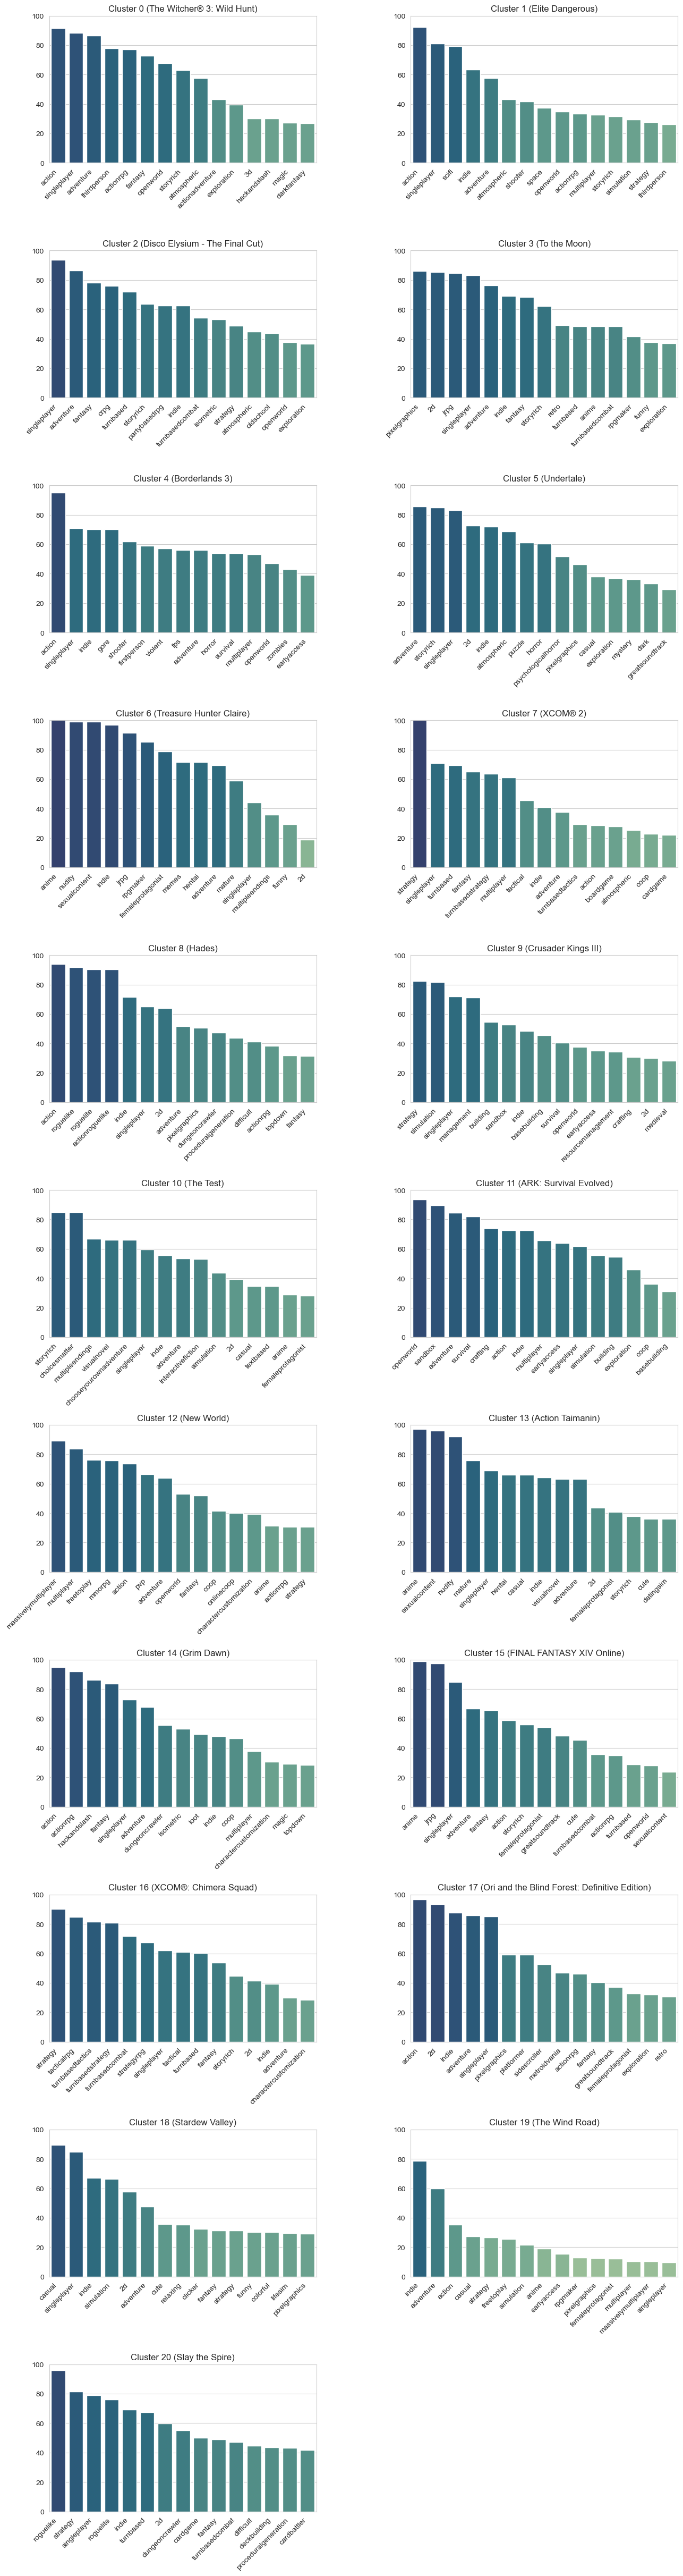

In [77]:
fig, axs = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 50))
fig.tight_layout(pad = 10.0)

for n in range(n_clusters):
    i_n = X[np.where(labels == n)]
    N = len(X[i_n])
    
    tag_percentages = sum(i_n, 1) * 100 / N
    
    i_common = np.argsort(-tag_percentages)[0:15]
    common_tags_per = tag_percentages[i_common]
    common_tags = features[i_common]
    
    plot_df = pd.DataFrame({'x': common_tags, 'y': common_tags_per})
    plot_df['hue'] = plot_df.apply(lambda row: (row['y'] > 66 and 2) or (row['y'] > 33 and 1) or 0, axis = 1)
    
    palette = sns.color_palette("crest", 15)
    color_i = np.floor(common_tags_per*15/100).astype(np.int32) - 1
    sns.barplot(ax = axs[n//2, n%2], x = common_tags, y = common_tags_per, 
                palette = np.array(palette).take(color_i, axis = 0))
    
    axs[n//2, n%2].set_xticklabels(common_tags[0:15], rotation = 45, ha = 'right')
    axs[n//2, n%2].set_ylim(0, 100)
    axs[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')

if n_clusters%2 == 1:
    axs[-1, -1].axis('off')

    
plt.show()

## Trend Analysis

In [69]:
import datetime

In [70]:
rpg_cluster[['release_year', 'release_month', 'release_day']].describe()

,release_year,release_month,release_day
count,3379.000000,3379.000000,3379.000000
mean,2017.781592,6.576206,16.004735
std,4.206511,3.451222,8.813238
min,1985.000000,1.000000,1.000000
25%,2016.000000,3.000000,9.000000
50%,2019.000000,7.000000,16.000000
75%,2021.000000,10.000000,23.000000
max,2023.000000,12.000000,31.000000


In [71]:
rpg_cluster['release_date'] = rpg_cluster['release_year']*10000 + rpg_cluster['release_month']*100 + rpg_cluster['release_day']
rpg_cluster['release_date'] = pd.to_datetime(rpg_cluster['release_date'], format='%Y%m%d')

C:\Users\Rlees\AppData\Local\Temp\ipykernel_15568\3119840146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpg_cluster['release_date'] = rpg_cluster['release_year']*10000 + rpg_cluster['release_month']*100 + rpg_cluster['release_day']
C:\Users\Rlees\AppData\Local\Temp\ipykernel_15568\3119840146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpg_cluster['release_date'] = pd.to_datetime(rpg_cluster['release_date'], format='%Y%m%d')


In [72]:
rpg_cluster.drop(['release_year', 'release_month', 'release_day'], axis = 1, inplace = True)

C:\Users\Rlees\AppData\Local\Temp\ipykernel_15568\904896726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpg_cluster.drop(['release_year', 'release_month', 'release_day'], axis = 1, inplace = True)


In [80]:
rpg_cluster['release_q'] = rpg_cluster['release_date'].dt.to_period('Q')
rpg_cluster

C:\Users\Rlees\AppData\Local\Temp\ipykernel_15568\720498400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpg_cluster['release_q'] = rpg_cluster['release_date'].dt.to_period('Q')


,name,tags,num_reviews,num_positive_reviews,url,cluster,silhouette_coff,silhouette_coeff,release_date,release_q
0,EA SPORTS™ PGA TOUR™,"[coop, localcoop, onlinecoop, multiplayer, spo...",260.0,121.0,https://store.steampowered.com/app/1677350/EA_...,19,-0.134030,-0.134030,2023-04-06,2023Q2
1,Song Of The Prairie,"[drama, exploration, datingsim, openworld, ear...",110.0,98.0,https://store.steampowered.com/app/1350840/Son...,18,0.009252,0.009252,2023-04-06,2023Q2
2,EVERSPACE™ 2,"[openworld, 3d, atmospheric, actionadventure, ...",5575.0,4915.0,https://store.steampowered.com/app/1128920/EVE...,1,-0.009804,-0.009804,2023-04-06,2023Q2
3,Organs Please,"[survival, futuristic, simulation, basebuildin...",113.0,107.0,https://store.steampowered.com/app/1593780/Org...,9,-0.058147,-0.058147,2023-04-05,2023Q2
4,Spiritfall,"[hackandslash, cartoon, earlyaccess, cartoony,...",252.0,225.0,https://store.steampowered.com/app/1835240/Spi...,8,0.021931,0.021931,2023-04-03,2023Q2
...,...,...,...,...,...,...,...,...,...,...
3374,Dungeon Siege II,"[hackandslash, isometric, coop, loot, adventur...",2011.0,1466.0,https://store.steampowered.com/app/39200/Dunge...,14,0.177492,0.177492,2005-08-16,2005Q3
3375,Disciples II: Rise of the Elves,"[turnbased, atmospheric, turnbasedstrategy, cl...",982.0,843.0,https://store.steampowered.com/app/1630/Discip...,7,0.173321,0.173321,2006-07-06,2006Q3
3376,Disciples II: Gallean's Return,"[isometric, atmospheric, turnbased, singleplay...",1126.0,922.0,https://store.steampowered.com/app/1640/Discip...,7,-0.079932,-0.079932,2006-07-06,2006Q3
3377,The Ship: Murder Party,"[funny, difficult, firstperson, comedy, simula...",2538.0,2129.0,https://store.steampowered.com/app/2400/The_Sh...,4,-0.005347,-0.005347,2006-07-11,2006Q3


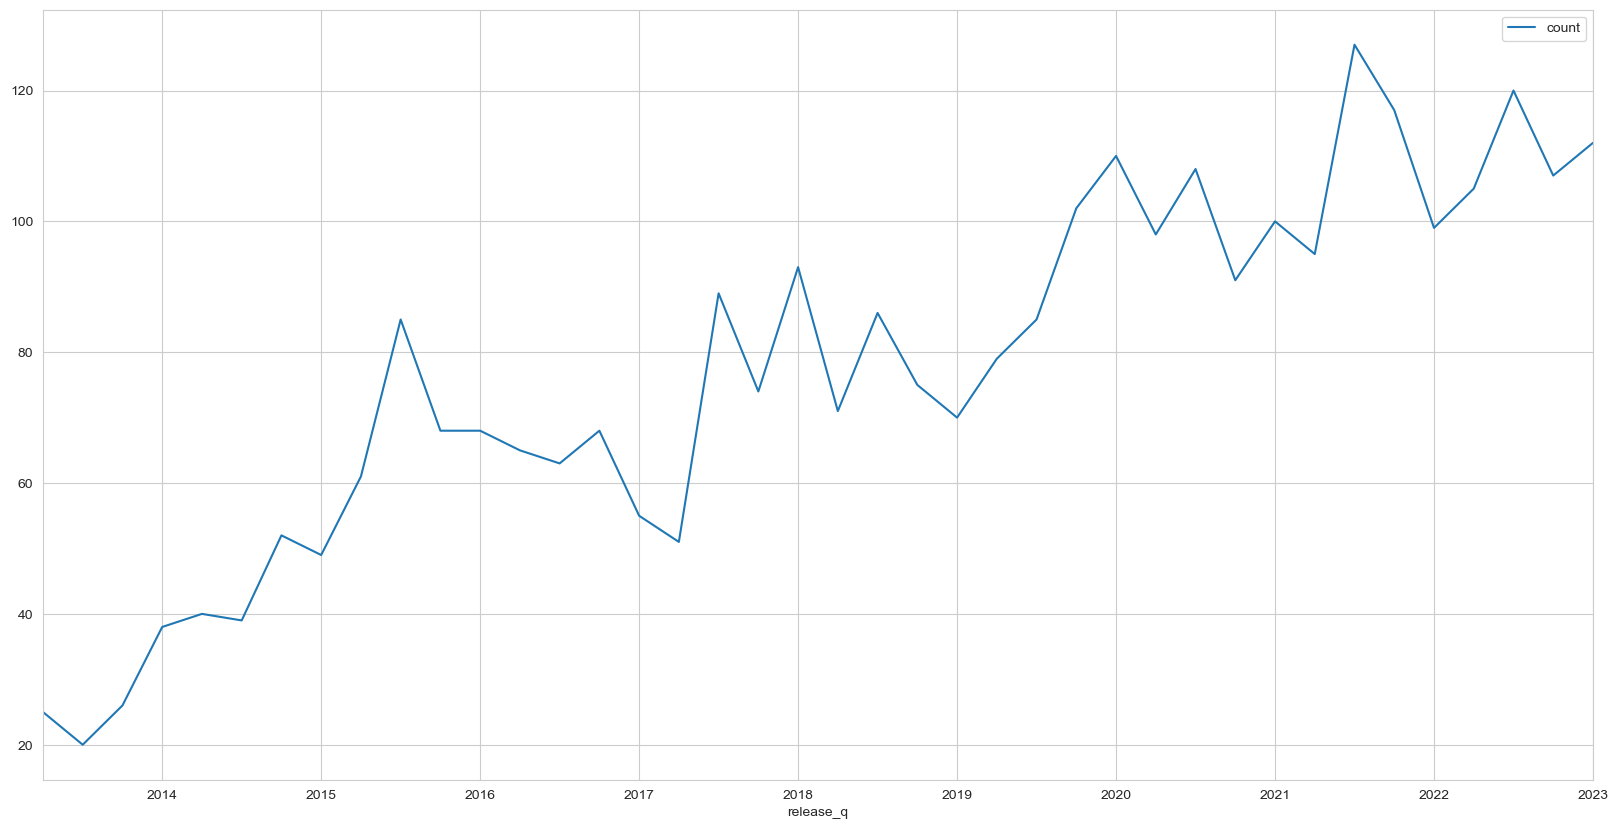

In [158]:
plot_df = rpg_cluster[('2013-04-01' <= rpg_cluster['release_date']) & (rpg_cluster['release_date'] < '2023-04-01')].groupby(['release_q','cluster']).agg(count=('cluster', 'count'))
plot_df.reset_index(inplace = True)
plot_df[['release_q', 'count']].groupby('release_q').sum().plot(figsize = (20, 10));

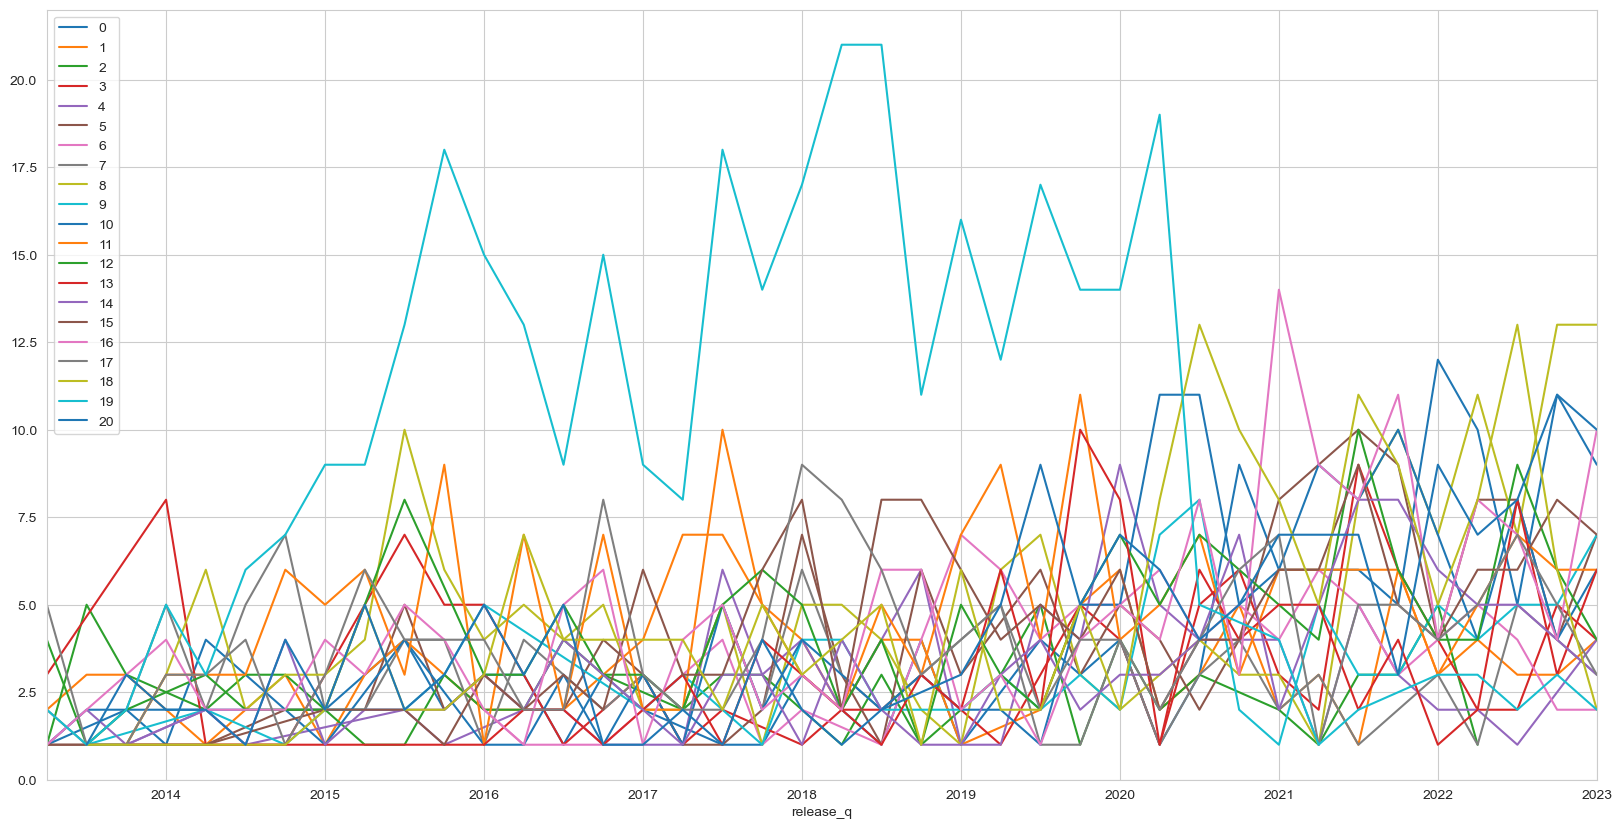

In [154]:
plot_df.set_index('release_q').groupby('cluster')['count'].plot(legend=True, figsize = (20, 10));

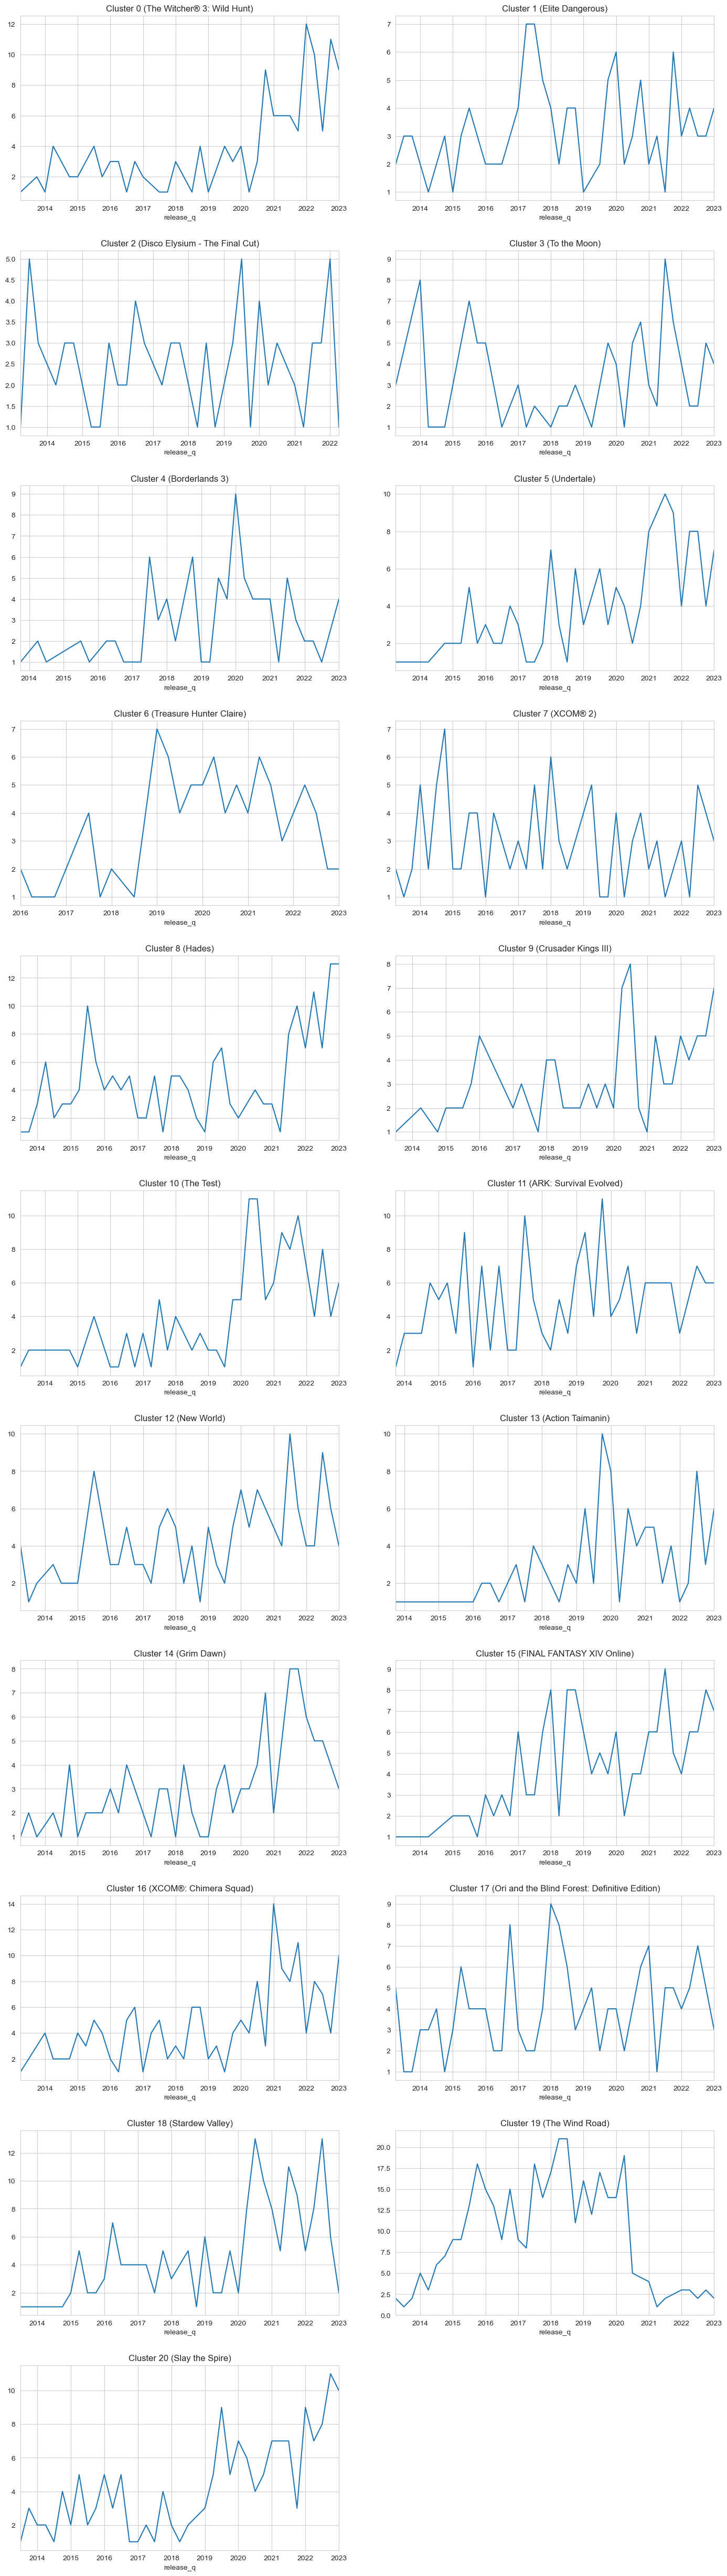

In [162]:
fig, axs = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 50))
fig.tight_layout(pad = 5.0)

for n in range(n_clusters):
    plot_df[plot_df['cluster'] == n].set_index('release_q').groupby('cluster')['count'].plot(ax = axs[n//2, n%2]);
    
    axs[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')

if n_clusters%2 == 1:
    axs[-1, -1].axis('off')

    
plt.show()